In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
x = np.fromfile('catkira/1876954_7680KSPS_srsRAN_Project_gnb_short.sigmf-data', 'int32')
cfo = 18.88  # Hz
phi0 = -2.4 # radians
sfo = -3e-6
x = (x[::2] + 1j * x[1::2]) / 2**31 * 24.7
# This should be the nominal RF frequency of the subcarrier that we use as DC for demodulation
f_dc = 1_876_950_000
fs = 7_680_000
x *= np.exp(-1j*(2*np.pi*cfo/fs*np.arange(x.size) + phi0))
Tu = 512
Ncp = 144 // 4
Ncpl = (144 + 16) // 4

In [3]:
# Pseudo-random sequence
def c_seq(init, length):
    crop = 1600
    x1 = np.zeros(crop + length, 'uint8')
    x2 = np.zeros(crop + length, 'uint8')
    x1[0] = 1
    j = 0
    for j in range(31):
        x2[j] = (init >> j) & 1
    for j in range(x1.size - 31):
        x1[j + 31] = x1[j + 3] ^ x1[j]
        x2[j + 31] = x2[j + 3] ^ x2[j + 2] ^ x2[j + 1] ^ x2[j]
    return x1[crop:] ^ x2[crop:]

## Poor man's Schmidl & Cox

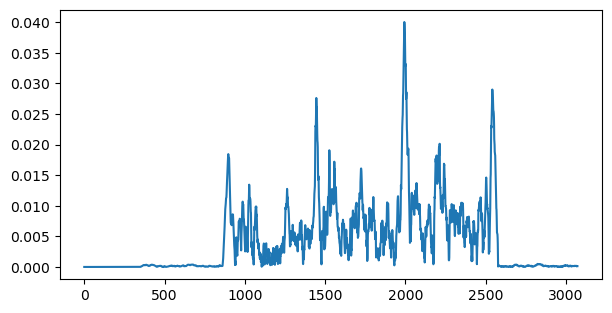

In [4]:
cp_corr = np.zeros(round(fs * 0.4e-3), 'complex')
corr_start = round(9.05e-3 * fs)
for j in range(cp_corr.size):
    y = x[corr_start + j:][:Ncp+Tu]
    cp_corr[j] = np.sum(y[:Ncp] * np.conjugate(y[-Ncp:]))

plt.plot(np.abs(cp_corr))

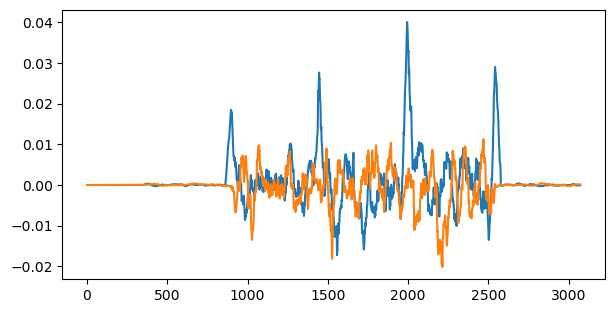

In [5]:
plt.plot(np.real(cp_corr))
plt.plot(np.imag(cp_corr))

In [6]:
m0 = np.argmax(np.abs(cp_corr[:1000]))
m1 = np.argmax(np.abs(cp_corr[1000:1500])) + 1000
m2 = np.argmax(np.abs(cp_corr[1500:2250])) + 1500
m3 = np.argmax(np.abs(cp_corr[2250:])) + 2250

In [7]:
# CFO estimates
-np.angle(cp_corr[[m0, m1, m2, m3]]) / (2 * np.pi) * (fs / Tu)

array([42.16428531, -6.20544002,  5.52347131, 42.04848156])

## PSS demodulation

In [8]:
a0 = corr_start + m0 + Ncp // 2
f = np.fft.fftshift(np.fft.fft(x[a0:a0+Tu]))
# correct for the 5G NR upconversion discontinuity
f *= np.exp(1j*2*np.pi*((a0*f_dc/fs) % 1))
# correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
f *= np.exp(1j*2*np.pi*np.fft.fftshift(np.fft.fftfreq(Tu))*Ncp/2)

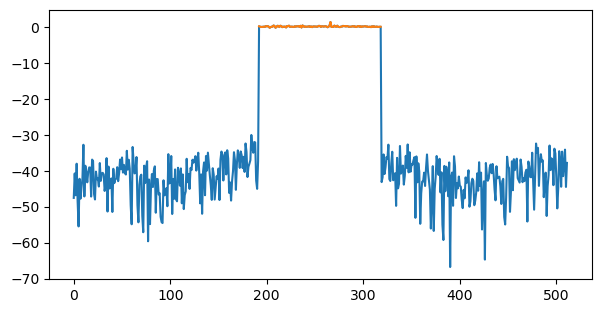

In [9]:
pss_sc_sel = range(Tu//2-120+56, Tu//2-120+56+127)
plt.plot(10*np.log10(np.abs(f)**2))
plt.plot(np.arange(f.size)[pss_sc_sel], 10*np.log10(np.abs(f[pss_sc_sel])**2))
pss_sym_demod = f[pss_sc_sel]

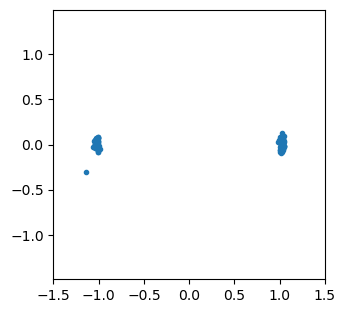

In [10]:
plt.figure(figsize=(3.5, 3.5))
plt.plot(pss_sym_demod.real, pss_sym_demod.imag, '.')
plt.axis('equal')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5);

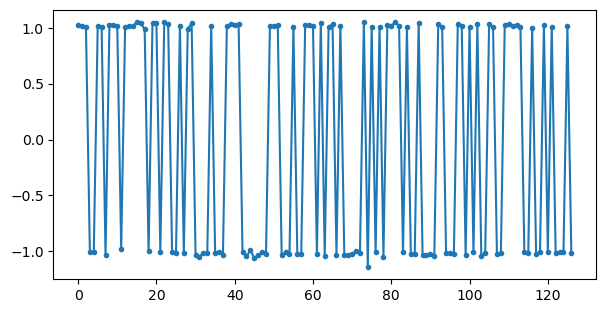

In [11]:
plt.plot(pss_sym_demod.real, '.-')

In [12]:
def pss_sequence(nid2):
    x = np.zeros(127, 'uint8')
    x[:7] = [1, 1, 1, 0, 1, 1, 0][::-1]
    for j in range(127 - 7):
        x[j + 7] = x[j + 4] ^ x[j]
    return 1 - 2 * x[(np.arange(127) + 43 * nid2) % 127].astype('float')

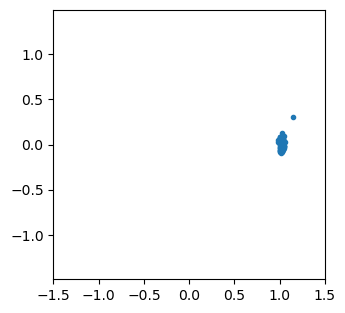

In [13]:
pss_sym_demod_wipe = pss_sym_demod * pss_sequence(1)

plt.figure(figsize=(3.5, 3.5))
plt.plot(pss_sym_demod_wipe.real, pss_sym_demod_wipe.imag, '.')
plt.axis('equal')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5);

In [14]:
np.angle(np.average(pss_sym_demod_wipe))

-0.002803059643476185

## PSS time domain correlation

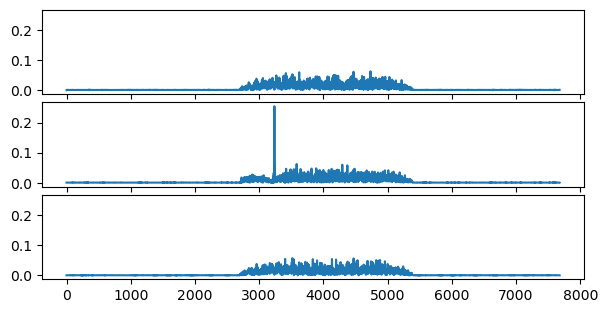

In [15]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)

for nid2 in range(3):
    pss_re = np.zeros(Tu, 'complex')
    pss_re[pss_sc_sel] = pss_sequence(nid2)
    pss_sym = np.fft.ifft(np.fft.fftshift(pss_re))
    pss_corr = np.zeros(round(fs * 1e-3), 'complex')
    corr_start = round(8.75e-3 * fs)
    for j in range(pss_corr.size):
        pss_corr[j] = np.sum(x[corr_start + j:][:Tu] * np.conjugate(pss_sym))
    axs[nid2].plot(np.abs(pss_corr))

plt.subplots_adjust(hspace=0.1);

In [16]:
NID2 = 1

## SSS demodulation

In [17]:
def sss_sequence(nid1, nid2, only_x1=False, no_x1=False):
    x0 = np.zeros(127, 'uint8')
    x1 = np.zeros(127, 'uint8')
    x0[0] = 1
    x1[0] = 1
    for j in range(127 - 7):
        x0[j + 7] = x0[j + 4] ^ x0[j]
        x1[j + 7] = x1[j + 1] ^ x1[j]
    if only_x1:
        return 1 - 2 * x1.astype('float')
    m0 = 15 * (nid1 // 112) + 5 * nid2
    m1 = nid1 % 112
    if no_x1:
        return 1 - 2 * x0[(np.arange(127) + m0) % 127].astype('float')
    return ((1 - 2 * x0[(np.arange(127) + m0) % 127].astype('float')) *
            (1 - 2 * x1[(np.arange(127) + m1) % 127].astype('float')))

In [18]:
f = np.fft.fftshift(np.fft.fft(x[a0+2*(Ncp + Tu):][:Tu]))
# correct for the 5G NR upconversion discontinuity
f *= np.exp(1j*2*np.pi*(((a0+2*(Ncp + Tu))*f_dc/fs) % 1))
# correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
f *= np.exp(1j*2*np.pi*np.fft.fftshift(np.fft.fftfreq(Tu))*Ncp/2)
sss_sym_demod = f[pss_sc_sel]

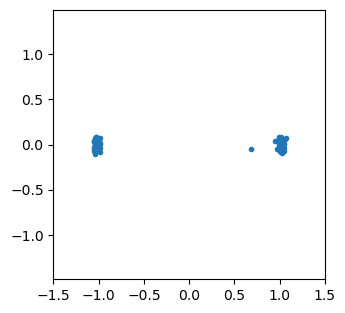

In [19]:
plt.figure(figsize=(3.5, 3.5))
plt.plot(sss_sym_demod.real, sss_sym_demod.imag, '.')
plt.axis('equal')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5);

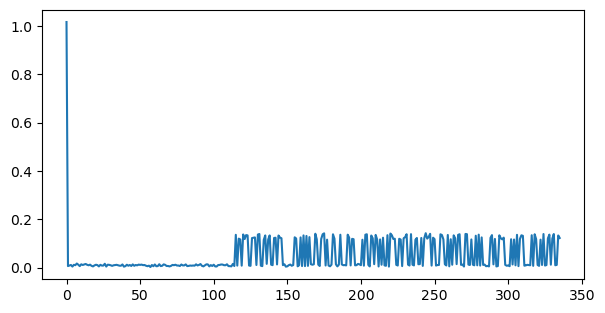

In [20]:
sss_corrs = np.empty(336, 'complex')
for j in range(sss_corrs.size):
    sss_corrs[j] = np.average(sss_sym_demod * sss_sequence(j, NID2))
plt.plot(np.abs(sss_corrs))

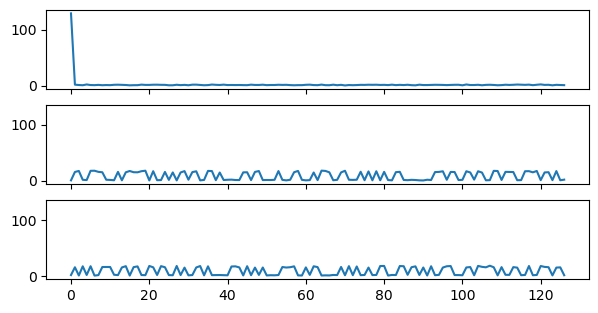

In [21]:
fig, axs = plt.subplots(3, sharex=True, sharey=True)
f_x1 = np.fft.fft(sss_sequence(0, 0, only_x1=True))
for j in range(3):
    f_sss_demod = np.fft.fft(sss_sym_demod * sss_sequence(j * 112, NID2, no_x1=True))
    corr_sss = np.fft.ifft(f_sss_demod * np.conjugate(f_x1))
    axs[j].plot(np.abs(corr_sss))

In [22]:
NID1 = 0
NcellID = 3 * NID1 + NID2
NcellID

1

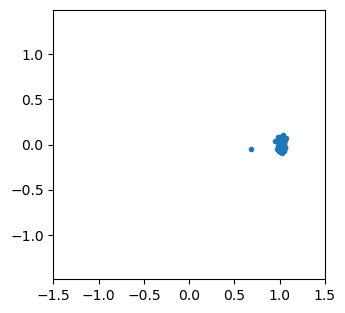

In [23]:
sss_sym_demod_wipe = sss_sym_demod * sss_sequence(NID1, NID2)

plt.figure(figsize=(3.5, 3.5))
plt.plot(sss_sym_demod_wipe.real, sss_sym_demod_wipe.imag, '.')
plt.axis('equal')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5);

In [24]:
((np.angle(np.average(sss_sym_demod_wipe)) - np.angle(np.average(pss_sym_demod_wipe))) / (2*np.pi) 
 * fs / (2 * (Tu + Ncp)))

-2.2820497809630393

## OFDM demodulation

In [25]:
Nsymbols = int((x.size - a0) / (1e-3 * fs) * 14)
symbols = np.empty((Nsymbols, Tu), 'complex')
for j in range(Nsymbols):
    off = a0 + j * (Ncp + Tu) + (j + 2) // 7 * (Ncpl - Ncp)
    # correct for SFO
    off_err = (off - a0) * sfo
    off_err_int = round(off_err)
    off_err_frac = off_err - off_err_int
    off_corr = off + off_err_int
    f = np.fft.fftshift(np.fft.fft(x[off_corr:off_corr+Tu]))
    # correct for the 5G NR upconversion discontinuity
    f *= np.exp(1j*2*np.pi*((off*f_dc/fs) % 1))
    # correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
    f *= np.exp(1j*2*np.pi*np.fft.fftshift(np.fft.fftfreq(Tu))*Ncp/2)
    # correct for fractional STO
    f *= np.exp(1j*2*np.pi*np.fft.fftshift(np.fft.fftfreq(Tu))*off_err_frac)
    symbols[j] = f

## Constellation plots

In [26]:
issb = 0
pbch_dmrs_seq = c_seq(2**11*(issb+1)*(NcellID//4 + 1) + 2**6*(issb+1) + (NcellID % 4), 288)
pbch_dmrs_seq = 1/np.sqrt(2) * ((1 - 2*pbch_dmrs_seq[::2].astype('float'))
                                + 1j * (1 - 2*pbch_dmrs_seq[1::2].astype('float')))

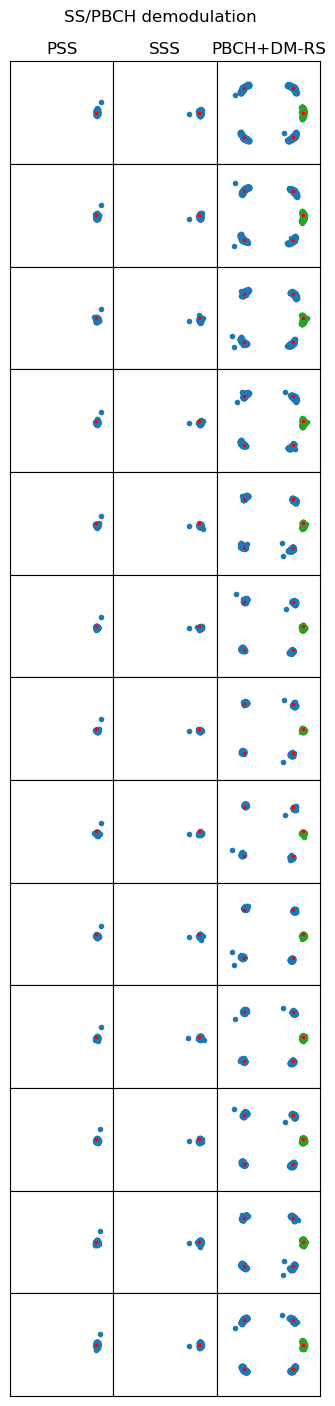

In [27]:
Nssblocks = Nsymbols // 140
plot_width = 4
fig, axs = plt.subplots(Nssblocks, 3, figsize=(plot_width, plot_width*Nssblocks/3))
for j in range(Nssblocks):
    s0 = j * 140
    pss = symbols[s0, pss_sc_sel] * pss_sequence(NID2)
    sss = symbols[s0 + 2, pss_sc_sel] * sss_sequence(NID1, NID2)
    pbch = np.concatenate([
        symbols[s0 + 1, Tu//2-120:Tu//2+120],
        symbols[s0 + 2, Tu//2-120:Tu//2-120+48],
        symbols[s0 + 2, Tu//2-120+192:Tu//2+120],
        symbols[s0 + 3, Tu//2-120:Tu//2+120],
    ])
    pbch_dmrs = pbch[NcellID % 4::4]
    pbch_dmrs_wipe = pbch_dmrs * np.conjugate(pbch_dmrs_seq)
    axs[j, 0].plot(pss.real, pss.imag, '.')
    axs[j, 1].plot(sss.real, sss.imag, '.')
    axs[j, 2].plot(pbch.real, pbch.imag, '.')
    axs[j, 2].plot(pbch_dmrs_wipe.real, pbch_dmrs_wipe.imag, '.', color='C2')
    for k in range(2):
        axs[j, k].plot([1], [0], '.', color='red', markersize=3)
    axs[j, 2].plot(np.array([1, 1, -1, -1])/np.sqrt(2),
                   np.array([1, -1, 1, -1])/np.sqrt(2),
                   '.', color='red', markersize=3)  
    axs[j, 2].plot([1], [0], '.', color='red', markersize=3)
for ax in axs.ravel():
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
plt.suptitle('SS/PBCH demodulation', y=0.91)
axs[0, 0].set_title('PSS');
axs[0, 1].set_title('SSS');
axs[0, 2].set_title('PBCH+DM-RS');

In [28]:
(np.angle(np.average(symbols[(Nssblocks-1)*140, pss_sc_sel] * pss_sequence(NID2))) 
 - np.angle(np.average(symbols[0, pss_sc_sel] * pss_sequence(NID2)))) / (2*np.pi*10e-3*Nssblocks)

0.010077570660166896

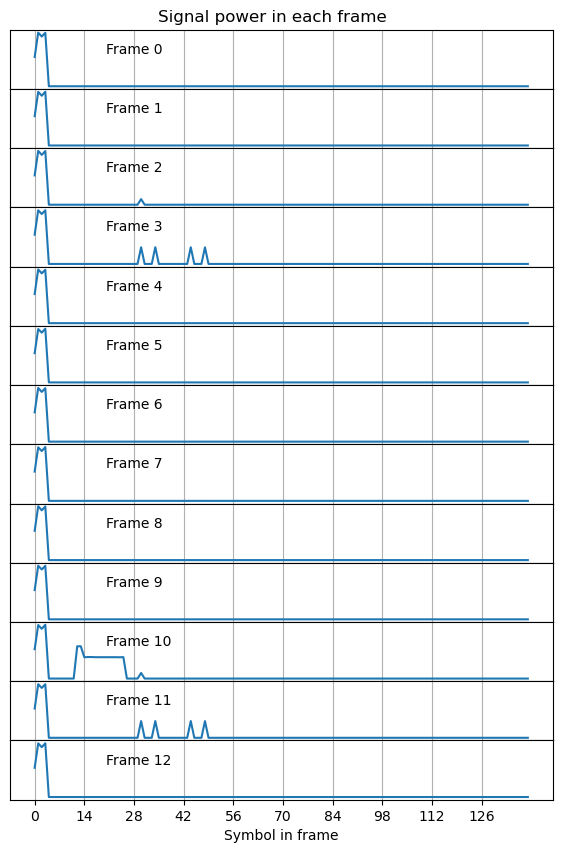

In [29]:
pwr_frame = np.sum(np.abs(symbols**2), axis=1)[:Nsymbols//140*140].reshape(-1, 140)
fig, axs = plt.subplots(13, figsize=(7, 10), sharex=True, sharey=True)
for j in range(pwr_frame.shape[0]):
    axs[j].plot(pwr_frame[j])
    axs[j].set_xticks(np.arange(0, 140, 14))
    axs[j].set_yticks([])
    axs[j].grid(axis='x')
    axs[j].text(20, 150, f'Frame {j}')
plt.subplots_adjust(hspace=0)
plt.suptitle('Signal power in each frame', y=0.90)
axs[-1].set_xlabel('Symbol in frame');

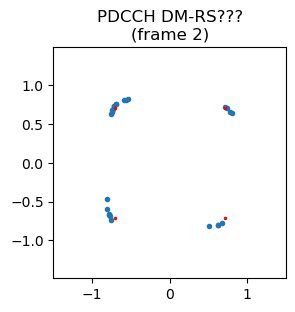

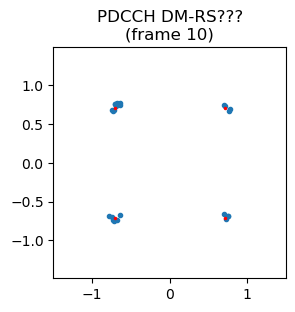

In [30]:
for k in [2, 10]:
    s = symbols[k*140+30, 127:427:12]
    plt.figure(figsize=(3, 3))
    plt.plot(s.real, s.imag, '.')
    plt.title(f'PDCCH DM-RS???\n(frame {k})')
    plt.axis('equal')
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.plot(np.array([1, 1, -1, -1])/np.sqrt(2),
             np.array([1, -1, 1, -1])/np.sqrt(2),
                      '.', color='red', markersize=3)

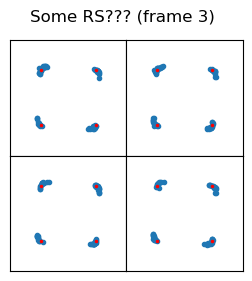

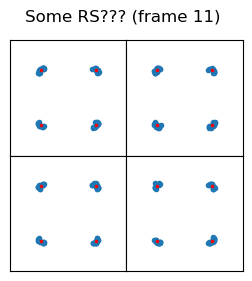

In [31]:
for k in [3, 11]:
    s = symbols[k*140+30+np.array([0, 4, 14, 18]), 116:416:4]
    fig, axs = plt.subplots(2, 2, figsize=(3, 3))
    axs = axs.ravel()
    for j in range(s.shape[0]):
        axs[j].plot(s[j].real, s[j].imag, '.')
        axs[j].axis('equal')
        axs[j].set_xlim(-1.5, 1.5)
        axs[j].set_ylim(-1.5, 1.5)
        axs[j].set_xticks([])
        axs[j].set_yticks([])
        axs[j].plot(np.array([1, 1, -1, -1])/np.sqrt(2),
                    np.array([1, -1, 1, -1])/np.sqrt(2),
                    '.', color='red', markersize=3) 
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.suptitle(f'Some RS??? (frame {k})')

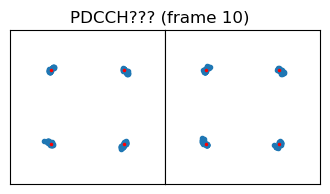

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
axs = axs.ravel()
for j in range(axs.size):
    s = symbols[10*140+12+j, np.concatenate((np.arange(164, 236), np.arange(308, 380)))]
    axs[j].plot(s.real, s.imag, '.')
    axs[j].axis('equal')
    axs[j].set_xlim(-1.5, 1.5)
    axs[j].set_ylim(-1.5, 1.5)
    axs[j].set_xticks([])
    axs[j].set_yticks([])
    axs[j].plot(np.array([1, 1, -1, -1])/np.sqrt(2),
                np.array([1, -1, 1, -1])/np.sqrt(2),
                '.', color='red', markersize=3)
plt.subplots_adjust(hspace=0, wspace=0)
plt.suptitle('PDCCH??? (frame 10)');

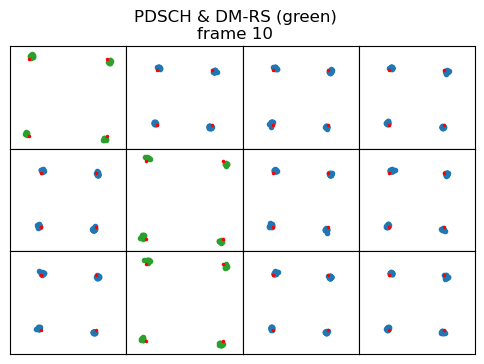

In [33]:
s = symbols[10*140+14+np.arange(12), 128:224]
fig, axs = plt.subplots(3, 4, figsize=(6, 4))
axs = axs.ravel()
for j in range(s.shape[0]):
    if j in [0, 5, 9]:
        axs[j].plot(s[j, ::2].real, s[j, ::2].imag, '.', color='C2')
        scale = 1
    else:
        axs[j].plot(s[j].real, s[j].imag, '.')
        scale = 1/np.sqrt(2)
    axs[j].axis('equal')
    axs[j].set_xlim(-1.5, 1.5)
    axs[j].set_ylim(-1.5, 1.5)
    axs[j].set_xticks([])
    axs[j].set_yticks([])
    axs[j].plot(np.array([1, 1, -1, -1])*scale,
                np.array([1, -1, 1, -1])*scale,
                '.', color='red', markersize=3) 
    plt.subplots_adjust(hspace=0, wspace=0)
plt.suptitle('PDSCH & DM-RS (green)\nframe 10', y=0.97);